In [1]:
%matplotlib inline

from IPython.display import Image,display

from numpy import pi

from qutip import *
import numpy as np
import matplotlib.pyplot as plt

First I'll create $|0><0|$ and $|1><1|$ and $|01><10|$ , they will be needed in the future.

In [2]:
zeromat = basis(2,0)*basis(2,0).trans()
oneomat = basis(2,1)* basis(2,1).trans()
display(zeromat,oneomat)
zero_one = tensor(basis(2,0),basis(2,1)) # |01>
zero_onemat = zero_one*zero_one.trans()
display(zero_onemat)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0.  0.]]

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.  0.]
 [ 0.  1.]]

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

## Building hamiltonian for the 2-SAT formula
I chose the formula 
$(x_1\vee \overline{x_2})
\wedge
(x_2\vee \overline{x_3})
\wedge
(x_3\vee \overline{x_1})
\wedge
(x_1\vee x_1)
$
the only solution for this formula is $x_1 =1 \quad   x_2 = 1 \quad  x_3 = 1$
Which will be encoded in the state $|111>$

Starting with $(x_1\vee \overline{x_2})$ this is equivalent to 
$|01><01|\otimes ID_3$

In [3]:
hamiltonian_terms = [] 
term1_hamiltonian = tensor(zero_onemat,qeye(2))
hamiltonian_terms.append(term1_hamiltonian)
display(term1_hamiltonian)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

The second term is $(x_2\vee \overline{x_3})$
So that will be 
$ID_1\otimes|01><01$

The third is 
$(x_3\vee \overline{x_1})$
will be
$|1><1| \otimes ID_2\otimes |0><0$

And finaly for $(x_1\vee x_1)$
We will have 
$|0><0| \otimes ID_{23}$


In [4]:
hamiltonian_terms.append(tensor(qeye(2),zero_onemat))
hamiltonian_terms.append(tensor(oneomat,qeye(2),zeromat))
hamiltonian_terms.append(tensor(zeromat,qeye(2),qeye(2)))

The final hamiltonian is the sum of this local terms

In [5]:
LH = sum(hamiltonian_terms)
display(LH)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Let's examine the ground states of the local hamiltonian LH 

In [6]:
print ("Energy %s" % LH.groundstate()[0])
print ("State")
display(LH.groundstate()[1])

Energy 0.0
State


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = [8, 1], type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]]

Indeed we got the $|111>$ state , just as we expected.

# Now lets Try doing some adiabatic computation

In [7]:
from IPython.core.debugger import Tracer

def simulate_adiabatic_process(tlist,H0,H1,rho0,draw):
    
    args = {'t_max': max(tlist)}
    h_t = [[H0, lambda t, args : (args['t_max']-t)/args['t_max']],
           [H1, lambda t, args : t/args['t_max']]]
    #
    # callback function for each time-step
    #
    N = 2
    M = 2
    evals_mat = np.zeros((len(tlist),M))
    P_mat = np.zeros((len(tlist),M))

    idx = [0]
    def process_rho(tau, psi):

        # evaluate the Hamiltonian with gradually switched on interaction 
        H = Qobj.evaluate(h_t, tau, args)

        # find the M lowest eigenvalues of the system
        evals, ekets = H.eigenstates(eigvals=M)

        evals_mat[idx[0],:] = np.real(evals)

        # find the overlap between the eigenstates and psi 
        for n, eket in enumerate(ekets):
            P_mat[idx[0],n] = abs((eket.dag().data * psi.data)[0,0])**2    

        idx[0] += 1

    output = sesolve(H=h_t,
                 rho0=rho0,
                 tlist=tlist,
                 e_ops=process_rho,
                 args = args)
    #rc('font', family='serif')
    #rc('font', size='10')
    if draw:
        fig, axes = plt.subplots(2, 1, figsize=(12,10))

        #
        # plot the energy eigenvalues
        #

        # first draw thin lines outlining the energy spectrum
        for n in range(len(evals_mat[0,:])):
            ls,lw = ('b',1) if n == 0 else ('k', 0.25)
            axes[0].plot(tlist/max(tlist), evals_mat[:,n] / (2*pi), ls, lw=lw)


        # second, draw line that encode the occupation probability of each state in 
        # its linewidth. thicker line => high occupation probability.
        for idx in range(len(tlist)-1):
            for n in range(len(P_mat[0,:])):
                lw = 0.5 + 4*P_mat[idx,n]    
                if lw > 0.55:
                   axes[0].plot(np.array([tlist[idx], tlist[idx+1]])/ max(tlist), 
                                np.array([evals_mat[idx,n], evals_mat[idx+1,n]])/(2*pi), 
                                'r', linewidth=lw)    
        axes[0].set_xlabel(r'$\tau$')
        axes[0].set_ylabel('Eigenenergies')
        axes[0].set_title("Energyspectrum (%d lowest values) of a chain of %d spins.\n " % (M,N)
                        + "The occupation probabilities are encoded in the red line widths.")

        #
        # plot the occupation probabilities for the few lowest eigenstates
        #
        for n in range(len(P_mat[0,:])):
            if n == 0:
                axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n], 'r', linewidth=2)
            else:
                axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n])

        axes[1].set_xlabel(r'$\tau$')
        axes[1].set_ylabel('Occupation probability')
        axes[1].set_title("Occupation probability of the %d lowest " % M +
                          "eigenstates for a chain of %d spins" % N)
        axes[1].legend(("Ground state",));

    return P_mat,evals_mat

## First we need to create a simple hamiltonian for which we know the ground state 
I will take the hamiltonian that gets 0 energy on $|000>$ and 1 on the rest of the computational basis.

In [8]:
zero10 = tensor([basis(2,0)]*10)
zero10_mat = zero10*zero10.trans()
id10 = tensor([qeye(2)]*10)
simple_ham = id10-zero10_mat 
simple_ham

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = [1024, 1024], type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]

In [9]:
psi0 = simple_ham.groundstate()[1]
simple_ham.groundstate()

(0.0,
 Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = [1024, 1], type = ket
 Qobj data =
 [[ 1.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]])

As expected , the ground state is |000>

Now we need to make sure that the two hamiltonians are not commuting, so I apply $H^{\otimes 3}$ on the first hamiltonian and it's groud state.

In [10]:
had_simple_ham = tensor([hadamard_transform()] * 10) * simple_ham * tensor([hadamard_transform()] * 10)
h10psi0 = tensor([hadamard_transform()] * 10) * psi0

In [19]:
bigLH = tensor(tensor([LH]*3),qeye(2))


In [20]:
bigLH

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = [1024, 1024], type = oper, isherm = True
Qobj data =
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

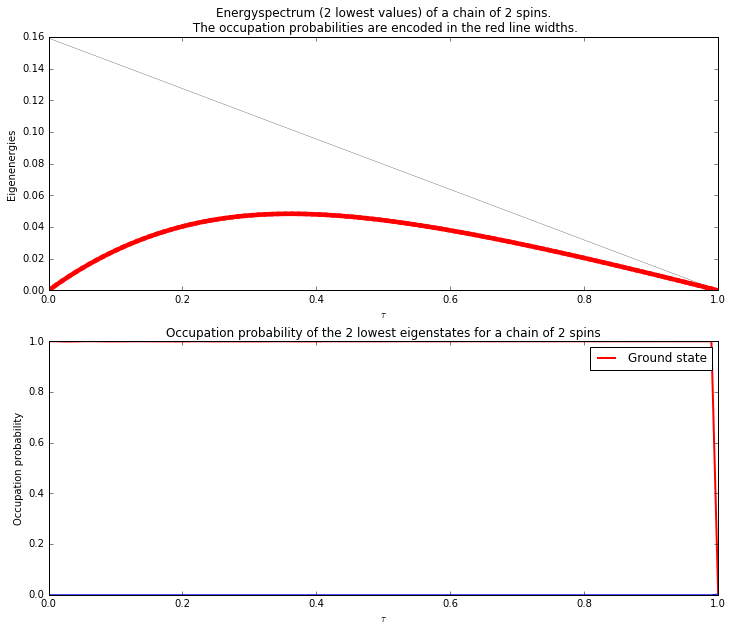

In [21]:
tlist = np.linspace(0, 100, 100)
P_mat,evals_mat =simulate_adiabatic_process(tlist,had_simple_ham,bigLH,h10psi0,True)

In [ ]:
list_of_pr_for_psi0 = []
for speed in range(1,100):
    tlist = np.linspace(0, speed, 100)
    P_mat,evals_mat =simulate_adiabatic_process(tlist,had_simple_ham,LH,h3psi0,False)
    pr_of_psi0=P_mat[-1][0]
    print(pr_of_psi0)
    list_of_pr_for_psi0.append(pr_of_psi0)
    

In [ ]:
plt.plot(list_of_pr_for_psi0)

In [ ]:
plt.plot(np.ones(99)-list_of_pr_for_psi0)